In [1]:
import cv2
import time
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
from IPython.display import clear_output

%run math_calibration.ipynb

arr = np.array

path = r'C:\nao_cv\geometrical\chessboard_images\\'

os.chdir(path)

size  = 38
shape = (7, 7)


files  = [f for f in listdir(path) if isfile(join(path, f))][::1]
photos = [x for x in files if (x[-4:] == '.jpg')]
strs   = [''.join([' ' if y == '_' else y for y in x]) for x in photos]
nums   = [[int(s) for s in x.split() if s.isdigit()][0] for x in strs]

frames = arr([dict(zip(['name', 'num'], x)) for x in arr([files, nums]).T])
frames = arr(sorted(frames, key = lambda k: int(k['num'])))


def text_data(frame, data):
    text = ''
    text += 'name:\n'
    text += '  %s\n' % (frame['name'])
    
    
    text += 'dist:  %s\n' % np.str(frame['num'])
            
        
    text += 'calc:\n'
    if (data == None):
        text += '  None\n'
    else:
        for i in range(len(data)):
            for key in data[i]:
                if (key not in ['opt_len', 'corners', 'optical']):
                    text += '  %s:  %s\n' % (key, np.str(np.around(data[i][key])))
            
    text += '\n'
    return text



i = 100

image = cv2.imread(frames[i]['name'])
data  = calibration_data(image, shape, size)

k = 2.5
plt.figure(figsize=(4*k, 3*k))

text = text_data(frames[i], data)
plt.gcf().text(0.76, 0.5, text, fontsize=14)

plt.imshow(image)

iteration:  445


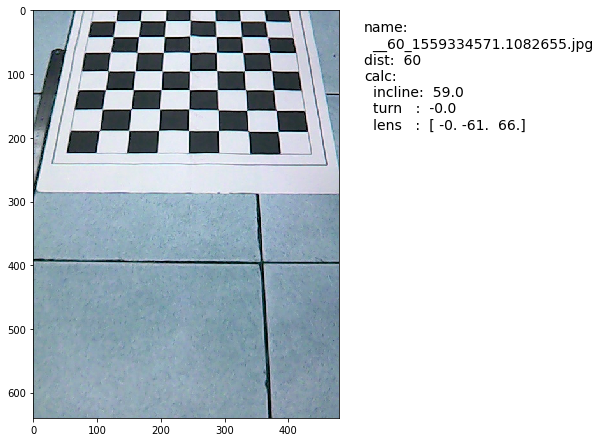

Press fucking key: end


In [2]:
i = 0
while (i <= len(frames)):
    
    clear_output()
    print ('iteration: ', i)
    
    
    k = 2.5
    plt.figure(figsize=(4*k, 3*k))
    
    image = cv2.imread(frames[i]['name'])
    data  = calibration_data(image, shape, size)
    
    text = text_data(frames[i], data)
    plt.gcf().text(0.76, 0.6, text, fontsize=14)
    
    plt.imshow(image)
    plt.show()
    
    key = input('Press fucking key: ')
    
    
    if (key == 'end'):
        break
        
    if (key != ''):
        i = int(key)
    else:
        i += 10

    if (i >= 889):
        i = 889

In [ ]:
250
